# Sentiment Classification

Sentiment Classification helps DisneyLand transform the humongous amounts of text data into actionable insights, enabling DisneyLand to improve their customer's experience and retention rate.

## Import libraries and download the packages

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.probability import FreqDist

## Read the dataset

In [2]:
df = pd.read_csv("sentiment_classification_reviews.csv")
df.head(5)

,sentiment,review_tokens
0,1,"['everyon', 'said', 'dai', 'christma', 'busies..."
1,1,"['went', 'great', 'much', 'better', 'kid', 'go..."
2,1,"['good', 'amus', 'crowd', 'look', 'food', 'wit..."
3,1,"['love', 'love', 'love', 'place', 'came', 'sin..."
4,1,"['somewher', 'financ', 'afford', 'freedom', 's..."


In [3]:
# When you save a list to a CSV file, it is automatically converted to a string. 
# When you re-open the CSV file, the string representation of the list is read back into your program as a string, 
# not a list.

# Therefore, I apply literal_eval to convert the lists in string format back to lists
import ast
df['review_tokens'] = df['review_tokens'].apply(ast.literal_eval)

In [4]:
# Append all the words in a list
cleaned_words = [words for lists in df['review_tokens'] for words in lists]

In [5]:
# Create a frequency distribution of the clean words
all_words_frequency = FreqDist(cleaned_words)
print (all_words_frequency)

print ("Top 10 most commonly occuring words:",all_words_frequency.most_common(10))

# get 2000 frequently occuring words
# most documents would have at least some words from the top 2000 words. Therefore, it might be a better feature set for
# classification.
most_common_words = all_words_frequency.most_common(2000)

# create word features
all_word_features = [item[0] for item in most_common_words]

<FreqDist with 16990 samples and 581573 outcomes>
Top 10 most commonly occuring words: [('ride', 11943), ('time', 9107), ('dai', 7215), ('line', 6028), ('pass', 5315), ('place', 5179), ('wait', 5174), ('on', 4464), ('peopl', 3846), ('like', 3617)]


## Creating Feature Sets (10mins to run entire)

### Create a Top 2000 Feature Set

Creating a feature set of the top 2000 words for dimensionality reduction. The model will look at the presence of frequently occuring words in the texts to classify the texts, rather than looking at words with only a few occurrence among multiple texts which may not be accurate in classification and create noise during the classification.

In [6]:
# Feature set with only the top 2000 
def document_features(df, stemmed_tokens):
    doc_features = []
    for index, row in df.iterrows():
        features = {}
        for word in all_word_features:
            # get term occurence: true if it's in the word_features, false if it's not
            features[word] = (word in row[stemmed_tokens])
        doc_features.append(features)
    return doc_features

all_words_feature_set = pd.DataFrame(document_features(df, 'review_tokens'), index = df.index)
all_words_feature_set.head()

,ride,time,dai,line,pass,place,wait,on,peopl,like,...,justifi,equip,solo,fairi,suddenli,jolli,cranki,wine,observ,blown
0,True,True,True,True,True,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,True,False,True,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


### Create Term Frequency (TF) Bag of Words

A Term Frequency Bag of Words generates a collection of text documents into numerical feature vectors. This might provide a better performance than a normal Bag of Words as it shows the occurrence of individual terms in the text and possibly provide some context which may increase the sentiment of the text.

In [7]:
import gensim
from gensim import corpora

# Build the dictionary
mydict = corpora.Dictionary(df['review_tokens'])
vocab_len = len(mydict)

def get_bow_features(df, stemmed_tokens):
    test_features = []
    for index, row in df.iterrows():
        # Converting the tokens into the format that the model requires
        features = gensim.matutils.corpus2csc([mydict.doc2bow(row[stemmed_tokens])],num_terms=vocab_len).toarray()[:,0]
        test_features.append(features)
    return test_features

header = ",".join(str(mydict[ele]) for ele in range(vocab_len))

bow_all_word_features = pd.DataFrame(get_bow_features(df, 'review_tokens'),                            
                            columns=header.split(','), index = df.index)

bow_all_word_features.head()

,advantag,afternoon,area,around,attitud,best,break,busiest,came,cast,...,centimet,activitiesif,chidrenkid,childrenkid,kidschildren,silverni,thristi,car😞,nomor,disregarddisrespect
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create Term Frequency-Inverse Document Frequency (TF-IDF) Bag of Words

TF-IDF Assigns more weight to rare words and less weight to commonly occurring words. It tells us how frequent a word is in a document relative to its frequency in the entire corpus and evaluates the importance of a term in a corpus (a large set of text). This allows low frequency words that are potentially important in classification to have a higher weight in the classification process.

In [8]:
from gensim.models import TfidfModel
# Build the dictionary
mydict = corpora.Dictionary(df['review_tokens'])
vocab_len = len(mydict)
corpus = [mydict.doc2bow(line) for line in df['review_tokens']]
tfidf_model = TfidfModel(corpus)

def get_tfidf_features(df, stemmed_tokens):
    test_features_tfidf = []
    for index, row in df.iterrows():
        doc = mydict.doc2bow(row[stemmed_tokens])
        # Converting the tokens into the formet that the model requires
        features = gensim.matutils.corpus2csc([tfidf_model[doc]], num_terms=vocab_len).toarray()[:,0]
        test_features_tfidf.append(features)
    return test_features_tfidf

header = ",".join(str(mydict[ele]) for ele in range(vocab_len))

tfidf_all_words_features = pd.DataFrame(get_tfidf_features(df, 'review_tokens'),                            
                            columns=header.split(','), index = df.index)
tfidf_all_words_features.head()

,advantag,afternoon,area,around,attitud,best,break,busiest,came,cast,...,centimet,activitiesif,chidrenkid,childrenkid,kidschildren,silverni,thristi,car😞,nomor,disregarddisrespect
0,0.111339,0.116593,0.076398,0.056851,0.114436,0.062524,0.08257,0.138444,0.081736,0.071874,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.071694,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.216771,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelling

In the modelling section, I will be using the following models for sentiment classification:
1. Random Forest
2. Logistic Regression
3. Extreme Gradient Boosting (XGB) Classifier

Random Forest Classifier is an ensemble method that creates and uses the result of multiple decision trees to make a prediction; it can handle non-linear relationships and high-dimensional data. It also has the feature_importances_ attribute, which reveals which features are influential in determining the sentiment of a text. 

Logistic Regression is a linear model that models the relationship between the features and the target variable as a linear combination. Logistic Regression also has the coef_ attribute, revealing the weight of terms in the two sentiment classes. Additionally, it can handle large datasets and be tuned to be more regularized to avoid overfitting, making it a good choice for sentiment analysis.

As with Random Forest Classifiers, XGBoost combines multiple decision trees to make predictions. Therefore, it can handle non-linear relationships and high-dimensional data. It can also handle large datasets and has the feature_importances_ attrbiute which can be used to understand what features are important in determining the sentiment of a text.

Therefore, I will use these 3 models due to its good performance and classification approaches.

### Evaluation Criteria

AUC-ROC is a metric that measures the ability of a model to distinguish between positive and negative classes. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold values and computes the area under the resulting curve.

The AUC-ROC is a robust metric that is insensitive to class imbalance, so it can be used to evaluate the performance of the sentiment analysis model with a class distribution of 60:40 for positive:negative respectively. A high AUC-ROC value indicates that the model is able to distinguish between positive and negative instances, regardless of the class distribution.

ROC-AUC is expressed as a decimal value ranging from 0 to 1.

A value of 0.5 represents a random guess, while a value of 1 represents a perfect model that perfectly separates positive and negative classes. A value of 0 represents a model that performs worse than random guessing.

 Thus, I will look for a model that produces the highest AUC-ROC score.

In [9]:
# pip install xgboost

In [10]:
# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Import metric scores
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Import train test split and seaborn
import seaborn as sns
from sklearn.model_selection import train_test_split

In [11]:
# Specifying the random_state to ensure reproducable results
models = []
models.append(('LR', LogisticRegression(random_state=1)))
models.append(('RF', RandomForestClassifier(random_state=1)))
models.append(('XGB', XGBClassifier(random_state=1)))

### Testing with Feature Set

Train the LR model now.
Train the RF model now.
Train the XGB model now.


,Name,ROC-AUC
0,LR with Top 2000 Feature Set,0.902832
2,XGB with Top 2000 Feature Set,0.888097
1,RF with Top 2000 Feature Set,0.880570


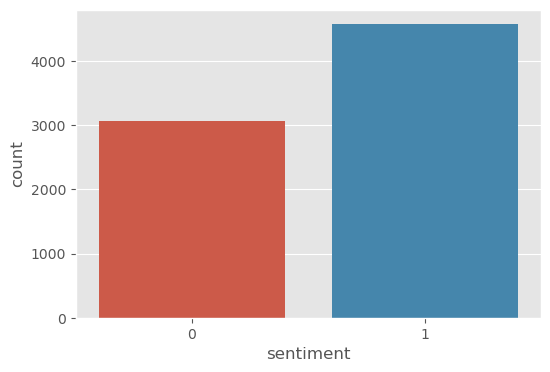

In [12]:
X = all_words_feature_set # x is the columns, pass into the model
y = df[['sentiment']] # y is the target variable, sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Stratify by the y column

#plot chart
plt.style.use('ggplot')
plt.figure(figsize=(6,4))
sns.countplot(data=y_train, x='sentiment')

# Testing with Kfold cross-validation and 10 folds.
from sklearn.model_selection import KFold
import sklearn.model_selection as model_selection

names = []
scores = []
for name,model in models:
    print("Train the",name,"model now.")
    
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))
    names.append(name+" with Top 2000 Feature Set")

models_comparison = pd.DataFrame({'Name':names, 'ROC-AUC':scores})
models_comparison.sort_values(by='ROC-AUC', ascending=False)

Based on the results of the classifiers, Logistic Regression has the best ROC-AUC score of 90.28%. The classes after splitting the data into train data is also quite balanced of around 40%:60% in the negative (0) and positive (1) sentiment respective.

### Testing with Term Frequency Bag of Words

Train the LR now.


C:\Users\fangg\anaconda3_new\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train the RF now.
Train the XGB now.


,Name,ROC-AUC
0,LR with Top 2000 Feature Set,0.902832
3,LR with Term Frequency Feature Set,0.901075
2,XGB with Top 2000 Feature Set,0.888097
5,XGB with Term Frequency Feature Set,0.885937
1,RF with Top 2000 Feature Set,0.880570
4,RF with Term Frequency Feature Set,0.875808


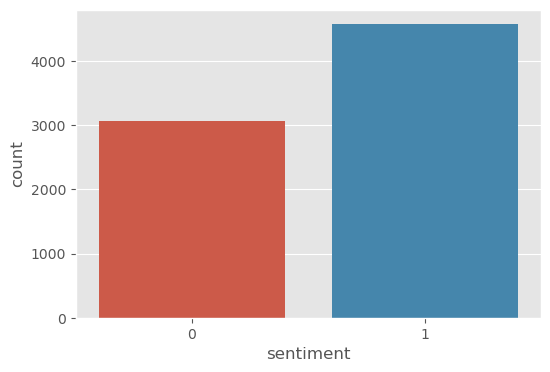

In [13]:
X = bow_all_word_features # x is the columns, pass into the model
y = df[['sentiment']] # y is the target variable, sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Stratify by the y column

#plot chart
plt.style.use('ggplot')
plt.figure(figsize=(6,4))
sns.countplot(data=y_train, x='sentiment')

for name,model in models:
    print("Train the",name,"now.")
    
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))
    names.append(name+" with Term Frequency Feature Set")

models_comparison = pd.DataFrame({'Name':names, 'ROC-AUC':scores})
models_comparison.sort_values(by='ROC-AUC', ascending=False)

Compared to using the top 2000 feature set containing all words, the Term Frequency Bag of Words Feature Set performed worse, with the highest ROC-AUC being 90.10% compared to 90.28% previously.

This decline in performance could be due to the other words creating noise within the machine, preventing the machine from accurately classify the text to its respective sentiments.

### Testing with a feature of TF-IDF Bag of Words

Train the LR now.
Train the RF now.
Train the XGB now.


,Name,ROC-AUC
6,LR with TFIDF Feature Set,0.912423
0,LR with Top 2000 Feature Set,0.902832
3,LR with Term Frequency Feature Set,0.901075
8,XGB with TFIDF Feature Set,0.888478
2,XGB with Top 2000 Feature Set,0.888097
5,XGB with Term Frequency Feature Set,0.885937
1,RF with Top 2000 Feature Set,0.880570
4,RF with Term Frequency Feature Set,0.875808
7,RF with TFIDF Feature Set,0.873133


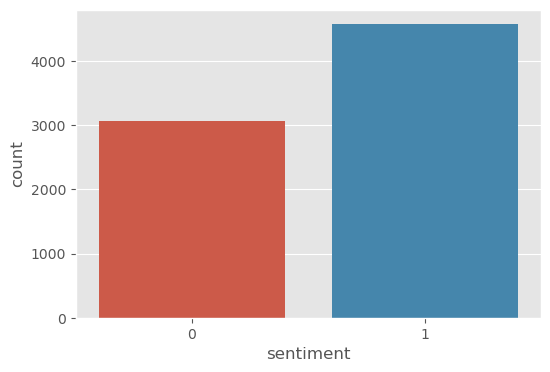

In [14]:
X = tfidf_all_words_features # x is the columns, pass into the model
y = df[['sentiment']] # y is the target variable, sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Stratify by the y column

#plot chart
plt.style.use('ggplot')
plt.figure(figsize=(6,4))
sns.countplot(data=y_train, x='sentiment')

for name,model in models:
    print("Train the",name,"now.")
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    scores.append(roc_auc_score(y_test, y_pred))
    names.append(name+" with TFIDF Feature Set")

models_comparison = pd.DataFrame({'Name':names, 'ROC-AUC':scores})
models_comparison.sort_values(by='ROC-AUC', ascending=False)

Compared to using the Term Frequency Bag of Words, the TF-IDF Bag of Words Feature Set performed slightly better, with the highest accuracy being 91.24% compared to 90.28% previously.

This improvement in performance could be due to the fact that TF-IDF assigned more weight to rare words and less weight to commonly occurring words, which could have been crucial in classifying the text's sentiment.

### Selecting best model

Based on the 3 different feature sets and models, the Logistic Regression with a feature set of TF-IDF Bag of Words performed the best. It has a classification accuracy of 91.24%. Therefore, I decided to tune this model to achieve better results.

In [15]:
X = tfidf_all_words_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Create a list to store the results
names = []
scores = []

In [16]:
# Base model for comparison
classifier = LogisticRegression(random_state=1)
classifier.fit(X_train, y_train.values.ravel())

names.append("Non-tuned (LBFGS solver, C=1) model")
y_pred = classifier.predict(X_test) 
roc_score = roc_auc_score(y_test, y_pred)
scores.append(roc_score)
print("ROC_AUC Score: " + str(roc_score))

ROC_AUC Score: 0.9124234592862915


### Model Tuning

I will try tuning the different model's parameter to improve the classification accuracy.

In [17]:
print("Possible parameters to be tuned for the Logistic Regression Classifier:")
LogisticRegression().get_params().keys()

Possible parameters to be tuned for the Logistic Regression Classifier:


dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

Of these parameters, I will only tune the following parameters:
    
C - C is the inverse of regularization strength. the default C value is 1.0. a smaller value specifies stronger regularization. tuning the regularization strength may increase the generalization performance of unseen data.

solver - The default solver is 'lbfgs'. 'saga' is a suitable optimization algorithm for logistic regression models when handling sparse data, large-scale datasets, or when L1 regularization is used. Therefore, I test the 'saga' solver for optimzation problem.

In [18]:
# Trying a stronger regularization.
classifier = LogisticRegression(C=0.5,  random_state=1)
classifier.fit(X_train, y_train.values.ravel())

names.append("Tuned (C=0.5, LBFGS solver) Model")
y_pred = classifier.predict(X_test) 
roc_score = roc_auc_score(y_test, y_pred)

scores.append(roc_score)
print("ROC_AUC Score: " + str(roc_score))

ROC_AUC Score: 0.9030421408605858


With a stronger regularization, lower C value, the performance dropped to 90.30%. A stronger generalization may have caused the model to be too generalized, being unable to capture the relationship between the features and target variable. Thus the decline in classification performance.

In [19]:
# Trying a weaker regularization.
classifier = LogisticRegression(C=3,  random_state=1)
classifier.fit(X_train, y_train.values.ravel())

names.append("Tuned (C=3, LBFGS solver) Model")
y_pred = classifier.predict(X_test) 
roc_score = roc_auc_score(y_test, y_pred)

scores.append(roc_score)
print("ROC_AUC Score: " + str(roc_score))

ROC_AUC Score: 0.9150756908015779


A weaker regularization, higher C value, improve the performance to 91.50% compared to 91.24% before tuning. A weaker regularization makes the model less generalized, allowing the model to fit the training data better and capture the relationship between the features and target variables. 

In [20]:
# Trying a stronger regularization with SAGA solver
classifier = LogisticRegression(solver='saga', random_state=1)
classifier.fit(X_train, y_train.values.ravel())

names.append("Tuned (SAGA solver) Model")
y_pred = classifier.predict(X_test) 
roc_score = roc_auc_score(y_test, y_pred)

scores.append(roc_score)
print("ROC_AUC Score: " + str(roc_score))

ROC_AUC Score: 0.9124234592862915


When using a SAGA solver, the ROC_AUC score did not change. This could be due to the fact that the dataset is not that large, thus performing the same as an LBFGS solver.

# Evaluation - Best Model

In [21]:
models_comparison = pd.DataFrame({'Name':names, 'ROC-AUC':scores})
models_comparison.sort_values(by='ROC-AUC', ascending=False)

,Name,ROC-AUC
2,"Tuned (C=3, LBFGS solver) Model",0.915076
0,"Non-tuned (LBFGS solver, C=1) model",0.912423
3,Tuned (SAGA solver) Model,0.912423
1,"Tuned (C=0.5, LBFGS solver) Model",0.903042


The best model is the Logistic Regression with a C value of 3 and the LBFGS solver. It has an ROC_AUC value of 91.50%.

In [22]:
# Trying a stronger regularization.
classifier = LogisticRegression(C=3,  random_state=1)
classifier.fit(X_train, y_train.values.ravel())

names.append("Tuned (C=3, LBFGS solver) Model")
y_pred = classifier.predict(X_test) 
roc_score = roc_auc_score(y_test, y_pred)

scores.append(roc_score)
print("ROC_AUC Score: " + str(roc_score))

ROC_AUC Score: 0.9150756908015779


              precision    recall  f1-score   support

    positive       0.93      0.88      0.90      1313
    negative       0.92      0.96      0.94      1958

    accuracy                           0.92      3271
   macro avg       0.92      0.92      0.92      3271
weighted avg       0.92      0.92      0.92      3271

ROC_AUC Score: 0.9150756908015779
Accuracy Score: 0.9229593396514827


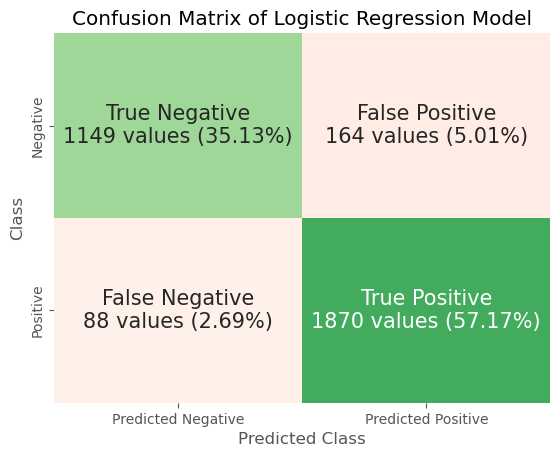

In [23]:
cm = confusion_matrix(y_test, y_pred)

names = ['True Negative','False Positive','False Negative','True Positive']
counts = ["{0:0.0f} values".format(value) for value in cm.flatten()]
percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2} ({v3})" for v1, v2, v3 in zip(names,counts,percentages)]
labels = np.asarray(labels).reshape(2,2)
ycategories = ['Negative', 'Positive']
xcategories = ['Predicted Negative', 'Predicted Positive']
off_diag_mask = np.eye(*cm.shape, dtype=bool)

fig = plt.figure()
con_mat = sns.heatmap(cm, annot=labels, annot_kws={"size": 15}, vmin=0, vmax=3000, mask=~off_diag_mask, cmap='Greens', fmt='', cbar=False, yticklabels=ycategories, xticklabels=xcategories)
con_mat = sns.heatmap(cm, annot=labels, annot_kws={"size": 15}, vmin=0, vmax=3000, mask=off_diag_mask, cmap='Reds', fmt='', cbar=False, yticklabels=ycategories, xticklabels=xcategories)
con_mat.set(xlabel="Predicted Class", ylabel="Class", title='Confusion Matrix of Logistic Regression Model')
con_mat

from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, y_pred,target_names=["positive","negative"]))

print("ROC_AUC Score: " + str(roc_auc_score(y_test, y_pred)))
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))

The Logistic Regression's classification is good with majority (92.29%) of the the texts being correctly classified. Meanwhile, the false positive and negative rate is low at only 7.70%. 

An ROC value of 0.5 represents a random guess, while a value of 1 represents a perfect model that perfectly separates positive and negative classes. A value of 0 represents a model that performs worse than random guessing. The classification has a high ROC_AUC score of 92.29%, which is roughly 7.71% away from being a perfect model. Therefore, Logistic Regression is the best model for classifying text with this dataset.

### Top words used for classification of a text

In [24]:
# Coefficients represent the relationship between the given feature and the target , 
# assuming that all the other features remain constant (conditional dependence).

# Positive coefficient belong to the positive sentiment class.
importances = list(classifier.coef_[0])
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(bow_all_word_features.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

top_i = 0
print("Top 10 keywords that classify a text to the positive sentiment:")
for pair in feature_importances:
    print('Variable: {:10} Importance: {}'.format(*pair))
    if top_i == 10:
        break
    top_i += 1

Top 10 keywords that classify a text to the positive sentiment:
Variable: great      Importance: 8.8998440781
Variable: love       Importance: 7.9448186703
Variable: amaz       Importance: 7.2777231534
Variable: best       Importance: 5.248116369
Variable: fun        Importance: 5.2415385269
Variable: alwai      Importance: 5.0228081782
Variable: awesom     Importance: 5.0171799744
Variable: fantast    Importance: 3.6193959614
Variable: blast      Importance: 3.555019994
Variable: perfect    Importance: 3.48589258
Variable: though     Importance: 3.4468942725


Looking at the top 10 words used to classify a text into the positive sentiment, the words are mostly emotion words. This explains why the text is able to perform well since emotion words occur commonly in texts.

In [25]:
# Coefficients represent the relationship between the given feature and the target , 
# assuming that all the other features remain constant (conditional dependence).

# Negative coefficient belong to the negative sentiment class.
importances = list(classifier.coef_[0])
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(bow_all_word_features.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# for pair in feature_importances:
#     print(pair)

importances = [(name, value) for (name,value) in feature_importances]
importances.sort(key=lambda i:i[1], reverse=False)
top_i = 0
print("Top 10 keywords that classify a text to the negative sentiment:")
for pair in importances:
    print('Variable: {:10} Importance: {}'.format(*pair))
    if top_i == 10:
        break
    top_i += 1

Top 10 keywords that classify a text to the negative sentiment:
Variable: monei      Importance: -6.886414802
Variable: rude       Importance: -6.2899262378
Variable: worst      Importance: -5.6608508226
Variable: hour       Importance: -5.2374685791
Variable: anymor     Importance: -5.0695771828
Variable: pai        Importance: -4.9930800332
Variable: horribl    Importance: -4.8758011639
Variable: peopl      Importance: -4.8404379365
Variable: paid       Importance: -4.7372928547
Variable: wast       Importance: -4.7184703266
Variable: disappoint Importance: -4.4719374393


These are the top 10 features that are mostly used to classify a text to the negative sentiment. The terms are mostly adverbs/adjectives such as 'horribl' and 'rude'. Therefore, adjectives/adverbs are necessary in sentiment analysis.

This also shows how well the Logistic Regression classifier learns from the data as all the terms used to classify the positive/negative sentiments in the model are correct terms used to determine the sentiment of a text from a human's perspective.

In addition, some of the negative aspects of DisneyLand could be identified from the keywords used to classify a text to the negative sentiment. This includes the terms: 'monei', 'rude', 'hour and wast', 'disappoint'.

These are all negative aspects of DisneyLand. 

Monei, or money, could refer to the prices of items in DisneyLand. The prices in DisneyLand are typically higher compared to outside DisneyLand which may cause customers to feel unhappy. Although DisneyLand needs to make an income, they could consider lowering the price to balance their profit with customer satisfaction.

'rude' could refer to the service staff in DisneyLand. Management at DisneyLand could consider supervising and monitoring how their staff interact with their customers to identify the issues. They could also reach out to customers who experience rude services and understand and resolve the issue.

'disappoint' could refer to the facilities or services at DisneyLand. Especially after the pandemic, some facilities might not have been maintained and may be broken or closed. Management could consider conducting periodic check ups on their facilities to prevent customers from encountering broken or closed facilities which may affect their experience.

'hour and wast' could refer to wasted hour in waiting for some services at DisneyLand due to overcrowding. DisneyLand is a popular tourist attraction and crowd control may be a problem. Waiting long hours for a service may cause unhappiness and unsatisfaction among visitors. Therefore, management needs to learn how to handle the crowd to reduce customer waiting time.